# FORT Atom Dynamics Simulator (FADS) #
Preston Huft, July 2019

For simulating atom dynamics in a far-off resonance trap (FORT), including
- chopped cooling
- release recapture temperature measurements
- power modulation resonance searches (parametric heating)

# notes and todo

- all methods added so far work
- do single atom case studies to test functionality
- make experiment class in which FORT on/off times, chopping phases,
    and drops are set, following our experiment cycle design
    - plot the waveform to check
    - do atom exp with 100% single atom loading and simulated "second"
        readout checking whether the atom position is within the FORT
        radius


# pseudocode here

do this with objects. have an atom class, an experiment class to set FORT on off times, etc. 
do this for several atoms, say 100: 
capture an atom with a random velocity corresponding to a given T, say 25 uK
integrate the differential eq for the FORT being on either continuously or chopped (state machine it?)
the eq should use the dipole force given a gaussian intensity profile in r, and whatever shape the focus is
calculate things like mean squared velocity in the FORT to track temp, kinetic energy

In [17]:
# %matplotlib notebook

## libraries
from matplotlib import pyplot as plt
import numpy as np
from numpy import *
from random import random as rand
from scipy.integrate import solve_ivp

## other files
from physconsts import *
from rbconsts import *
from rbensemble import RbEnsemble as ensemble

## make the display wide
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

In [7]:
## methods

def squarewave(d,tau,t,n):
    """ square wave with duty cycle 'd' and period 'tau' [s]
        evaluated at time 't' % tau. 
        'n': number of Fourier terms
    """
    t = t % tau
    
    term = lambda m: 2*(1-cos(m*pi*d))*sin(m*pi*t/tau)/(m*pi)
    sqwv = 0
    for i in range(1,n):
        sqwv += term(i)
    
    return sqwv

def fr_dipole(r,delta,w0,I0,dist='Gaussian'):
    """ Radial component of dipole force felt by an atom located at
        r. 
        'delta': light detuning from the relevant transition
        'w0': characteristic trap radius, e.g. gaussian waist
        'dist': trap cross section shape, e.g. poisson
        'I0': peak spatial intensity
    """
    
    # assume dist = Gaussian for now
    I = lambda x: I0*exp(-x**2/w0**2)
    gradI = lambda x: -2*I0*x*exp(-x**2/w0**2)/w0**2
    
    fdip = -(hbar*delta/2)*((gradI(r)/Isat)
                            /(1+4*(delta/gamma_D2)**2)+I(r)/Isat)
    return fdip

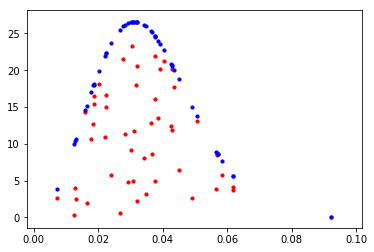

array([0.0159959 , 0.0128605 , 0.04267118, 0.03207185, 0.02398301,
       0.01252156, 0.05841582, 0.02665472, 0.02014433, 0.02253457,
       0.03008341, 0.03470635, 0.03653649, 0.02775304, 0.03758941,
       0.06183109, 0.03193306, 0.02931369, 0.03427004, 0.01853934,
       0.05699387, 0.03045087, 0.02209868, 0.04035926, 0.05681113,
       0.03085344, 0.03105674, 0.03753117, 0.031559  , 0.04297416,
       0.01870755, 0.01777445, 0.06170129, 0.03629541, 0.01306337,
       0.01641698, 0.0391638 , 0.02843064, 0.0385431 , 0.0491751 ,
       0.04358594, 0.0374834 , 0.04495431, 0.05648765, 0.04275918,
       0.0504972 , 0.0225025 , 0.01856957, 0.09223469, 0.00735656])

In [12]:
# maxwboltz test
atoms = ensemble(5e-6)
atoms.sampling_maxboltzv(50,[0,1],showplot=True)

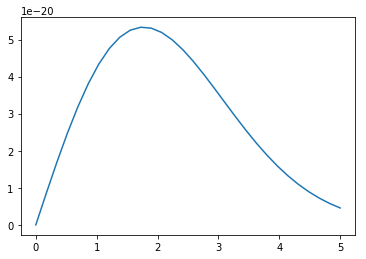

In [165]:
# fr_dipole test
w0 = 2.5e-6
D = 2e8
I0 = .4*.384/(pi*(w0)) 

rpts = linspace(0,5,30)
fpts = [fr_dipole(r*1e-6,D,w0,I0) for r in rpts]
plt.plot(rpts,fpts)

In [272]:
# FORT potential wrt inf and escape velocity
w0 = 2.5e-6
D = 2e8
I0 = .4*.384/(pi*(w0)) 
g = gamma_D2

# integral Fdip from 0 to inf in mathematica. Check Mark's notes
U = .5*hbar*w0**2*D*log(1+I0*g**2/(Isat*(g**2+4*D**2)))
U/kB # why is this so small?

# get escape vel from this

1.3158794269163735e-14

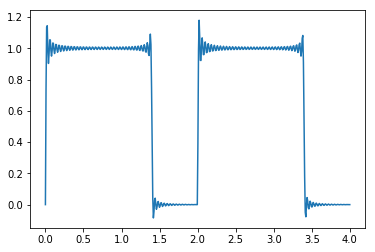

In [91]:
# squarewave test
tlist = linspace(0,4,500)
sqpts = [squarewave(0.7,2,t,100) for t in tlist]
plt.plot(tlist,sqpts)

In [376]:
## classes 

class Experiment():
    """ Do some science """
    
    global mRb

    ## experimental constants and methods
    w0 = 2.5e-6 # FORT width
    D = 2e8 # FORT detuning [Hz] from D2 cooling line
    I0 = .4*.384/(pi*(w0)) # FORT peak intensity
    lowpow = .7 # FORT low power setting [percentage]
    fdip = lambda r: fr_dipole(r,D,w0,I0) # FORT dipole F_r
    
    def __init__(self,atoms): 
        
        # later could just inherit RbEnsemble 
        self.atoms = atoms 
        
        # all times in [ms] for now
        self.t_exp = 100 
        self.t_FORTload = 0
        self.t_FORTdrop = [] # duration of FORT turned off
        self.t_chop = [] # duration of chopping
        self.chopduty = [] # chop duty cycle
        self.chopperiod = [] # chop period

        scan = self.t_FORTdrop # account for other vars later
        
    def derivs_on(self,t,y): 
        m = mRb

        v,r = y

        vdot = -fdip(r)/m
        rdot = v

        return [vdot,rdot]

    def derivs_off(self,t,y): 
        m = mRb

        v,r = y

        vdot = 0
        rdot = v

        return [vdot,rdot]
    
    def derivs_low(self,t,y): 
        m = mRb

        v,r = y

        vdot = -lowpow*fdip(r)/m
        rdot = v

        return [vdot,rdot]


    
    def derivs_chop(self,t,y):
        m = mRb

        v,r = y

        vdot = -fdip(r)*sqwv(t)/m
        rdot = v

        return [vdot,rdot] 
        
    def fort_temp(self,samples):
        """ release recapture 
            'samples' = number of measurements per data point
        """ 
        
        # not working; plot looks null, despite loop finishing, which implies
        # at least sample atoms were retained at loading... i guess.
        # no more programmatic errors though
        
        t_drop = 30e-3 # drop the FORT at .030 s
        t_exp = self.t_exp*1e-3 # convert to s
        t_steps = 500
        t_gap = self.t_FORTdrop*1e-3
        
        atoms = self.atoms
        
        retentions = np.empty(len(self.t_FORTdrop)) # atoms not lost to FORT drop
        
        for i,t_gap in enumerate(self.t_FORTdrop):
            retention = 0
            final_r = np.empty(samples)
            for s in range(samples):

                # FORT on CW
                tdomain = [0,t_drop]
                tlist = linspace(0,t_drop,t_steps)
                y0 = [atoms.xpt([0,w0]),atoms.vpt()]
    
#                 soln1 = solve_ivp(self.derivs_on,tdomain,y0,t_eval=tlist)
                
#                 # check if atom has been retained thus far
#                 r = soln1.y[0][-1]
#                 v = soln1.y[1][-1]
                
#                 final_r[s]=r
                
# #                 if r > w0: # abort this iteration
# #                     s -= 1 # don't advance the counter; 
# # #                     break
# #                 else:
# #                     retention+=1

                # FORT off 
                tdomain = [t_drop,t_gap]
                tlist = linspace(t_drop,t_gap,t_steps)
                soln2 = solve_ivp(self.derivs_off,tdomain,y0,t_eval=tlist)
                
                # atom still within FORT cross-section after t_gap?
                r = soln2.y[0][-1]
                if r <= w0:
                    retention += 1

#             plt.plot(final_r/(1e-6)) # plot the final r vals

            print(f"iter {i}: loading = {retention/samples}")
            retentions[i] = retention/samples
            
#         fig,ax = plt.subplots()
#         ax.plot(t_gap/(1e-3),retentions)
#         ax.set(xlim=[0,t_exp/(1e-3)],ylim=[0,1])
#         plt.show()

        #return [t_FORTdrop,retentions]
            

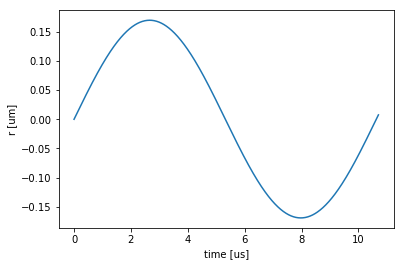

In [20]:
# ode solve test

tau = 8e-7 # 800 ns
texp = 10.7e-6
tlist = linspace(0,texp,1000)
sqwv = lambda t: squarewave(0.5,tau,t,100)
sqpts = [sqwv(t) for t in tlist]
# plt.plot(tlist/1e-9,sqpts)

w0 = 2.5e-6
D = 2e8
I0 = .4*.384/(pi*(w0)) 

fdip = lambda r: fr_dipole(r,D,w0,I0)

def derivs(t,y):
    global mRb
    m = mRb
    
    v,r = y
    
    vdot = -fdip(r)/m #*sqwv(t)/m
    rdot = v
    
    return [vdot,rdot]

tdomain = [0,texp]
y0 = [.1,0] # [v0 [m/s] ,r0 [m]]

soln = solve_ivp(derivs,tdomain,y0,t_eval=tlist)
# plt.plot(soln.t/1e-6,soln.y[1]/1e-6)

fig, ax = plt.subplots()
ax.plot(soln.t/1e-6,soln.y[1]/1e-6)
# ax.plot(soln.t/1e-6,sqpts)
ax.set(xlabel='time [us]', ylabel='r [um]')
plt.show()
    
# solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50))

0.6457451999082519 0.6457451999082517 0.6457451999082517


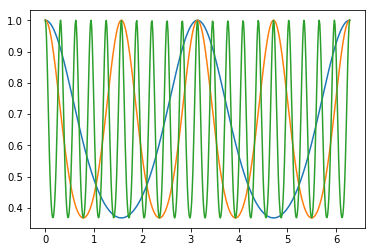

In [21]:
# the AC stark shift the atom sees
xpts = linspace(0,2*pi,500)
sine1 = [sin(x) for x in xpts]
sine2 = [sin(2*x) for x in xpts]
sine3 = [sin(10*x) for x in xpts]
acshift1 = [exp(-y**2) for y in sine1]
acshift2 = [exp(-y**2) for y in sine2]
acshift3 = [exp(-y**2) for y in sine3]

plt.plot(xpts,acshift1)
plt.plot(xpts,acshift2)
plt.plot(xpts,acshift3)
print(mean(acshift1),mean(acshift2),mean(acshift3))

In [24]:
(1/e)**2

0.1353352832366127

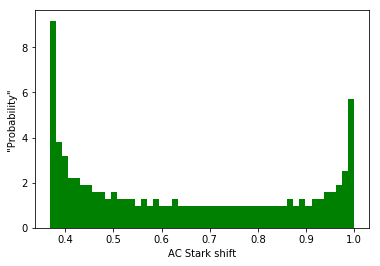

In [25]:
# time spent in various regions of stark shift histogram
n, bins, patches = plt.hist(acshift1, 50, density=True, facecolor='g')

plt.xlabel('AC Stark shift')
plt.ylabel('"Probability"')
plt.show()

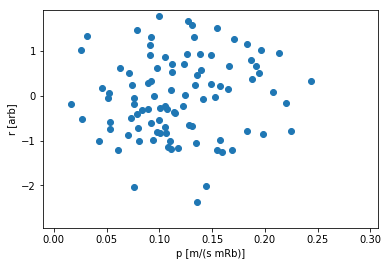

In [304]:
# RbEnsemble test
atoms = RbEnsemble(5e-5,100,xdist='normal')
atoms.phasespace()

In [377]:
# Experiment test. don't name the experiment 'exp' !!
atom = RbEnsemble(5e-5)
exp1 = Experiment(atom)
exp1.t_FORTdrop = np.array([0,0.002,0.004,0.008,0.01,0.012,0.014,0.016,0.018,
                            0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16]) # [ms]

In [378]:
exp1.fort_temp(10)

iter 0: loading = 1.0
iter 1: loading = 1.0
iter 2: loading = 1.0
iter 3: loading = 1.0
iter 4: loading = 1.0
iter 5: loading = 1.0
iter 6: loading = 1.0
iter 7: loading = 1.0
iter 8: loading = 1.0
iter 9: loading = 1.0
iter 10: loading = 1.0
iter 11: loading = 1.0
iter 12: loading = 1.0
iter 13: loading = 1.0
iter 14: loading = 1.0
iter 15: loading = 1.0
iter 16: loading = 1.0


In [ ]:
# HF level stark shifts -- only valid for two-level atom
def two_lvl_acstark(w,wab,matelem,efield):
    """ return the two level AC stark shift """
    return -ee**2/(2*hbar)*wab*matelem*abs(efield)**2/(wab**2-w**2)

In [ ]:
# coupling consts
# F, mF, J, q, FF, mFF, JJ, I, RME
D2F2cpl = hf_coupling(2,0,1/2,0,3,0,3/2,I,D2_MatElem)
D2F1cpl = hf_coupling(1,0,1/2,0,2,0,3/2,I,D2_MatElem)
D2F2cpl,D2F1cpl